# Option Pricing Models and Greeks
This notebook implements option pricing models for European and American options.

*   **Black-Scholes Model**: Calculate prices for European call and put options.
*   **Binomial Tree Model**: Price American options with early exercise capability.
*   **Market Data**: Integrate real-time option data from Yahoo Finance.
*   **Greeks Calculation**: Compute Delta, Gamma, Vega, Theta, and Rho for American options.
*   **Visualization**: Compare market prices with model prices using plots.
*   **Model Accuracy**: Assess model performance against market data.

Big thanks to everyone online for their helpful resources!

**Tags:** Option Pricing, Binomial Model, Black-Scholes, European Options, American Options, Quant Finance

#### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import yfinance as yf

#### Black-Scholes Model for European Options

In [2]:
class BlackScholesModel:
    def __init__(self, S0, K, T, r, q, sigma, option='C'):
        self.S0 = S0
        self.K = K
        self.T = T
        self.r = r
        self.q = q
        self.sigma = sigma
        self.option = option
    
    def d1(self):
        return (np.log(self.S0/self.K) + (self.r - self.q + 0.5*self.sigma**2)*self.T) / (self.sigma*np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.sigma*np.sqrt(self.T)
    
    def option_price(self):
        d1, d2 = self.d1(), self.d2()
        if self.option == 'C':
            price = self.S0*np.exp(-self.q*self.T)*norm.cdf(d1) - self.K*np.exp(-self.r*self.T)*norm.cdf(d2)
        else:
            price = self.K*np.exp(-self.r*self.T)*norm.cdf(-d2) - self.S0*np.exp(-self.q*self.T)*norm.cdf(-d1)
        return price
    
    def delta(self):
        d1 = self.d1()
        if self.option == 'C':
            return np.exp(-self.q*self.T) * norm.cdf(d1)
        else:
            return np.exp(-self.q*self.T) * (norm.cdf(d1) - 1)

    def gamma(self):
        d1 = self.d1()
        return np.exp(-self.q*self.T) * norm.pdf(d1) / (self.S0 * self.sigma * np.sqrt(self.T))

    def vega(self):
        d1 = self.d1()
        return self.S0 * np.exp(-self.q*self.T) * norm.pdf(d1) * np.sqrt(self.T)

    def theta(self):
        d1, d2 = self.d1(), self.d2()
        if self.option == 'C':
            theta = (-self.S0 * norm.pdf(d1) * self.sigma * np.exp(-self.q * self.T) / (2 * np.sqrt(self.T))
                     - self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
                     + self.q * self.S0 * np.exp(-self.q * self.T) * norm.cdf(d1))
        else:
            theta = (-self.S0 * norm.pdf(d1) * self.sigma * np.exp(-self.q * self.T) / (2 * np.sqrt(self.T))
                     + self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-d2)
                     - self.q * self.S0 * np.exp(-self.q * self.T) * norm.cdf(-d1))
        return theta / 365

    def rho(self):
        d2 = self.d2()
        if self.option == 'C':
            return self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(d2) / 100
        else:
            return -self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-d2) / 100


#### Binomial Tree Model for American Options

In [3]:
def binomial_american_fast_div(S0, K, T, r, q, std, N, optype='C'):
    dt = T / N
    a = np.exp((r - q) * dt)
    u = np.exp(std * np.sqrt(dt))
    d = 1 / u
    p = (a - d) / (u - d)
    disc = np.exp(-r * dt)
    
    S = S0 * d**(np.arange(N, -1, -1)) * u**(np.arange(0, N + 1, 1))
    
    if optype == 'C':
        C = np.maximum(S - K, 0)
    else:
        C = np.maximum(K - S, 0)
    
    for i in np.arange(N - 1, -1, -1):
        S = S0 * d**(np.arange(i, -1, -1)) * u**(np.arange(0, i + 1, 1))
        C[:i + 1] = disc * (p * C[1:i + 2] + (1 - p) * C[0:i + 1])
        C = C[:-1]
        if optype == 'C':
            C = np.maximum(S - K, C)
        else:
            C = np.maximum(K - S, C)
    
    return C[0], C

#### Fetching Market Data

In [4]:
# Fetching option chain data from Yahoo Finance for AAPL
ticker = 'AAPL'
stock = yf.Ticker(ticker)
options = stock.option_chain('2024-12-20')  # Set to an expiration date of your choice
calls = options.calls[['strike', 'lastPrice']]
stock_price = stock.history(period='1d')['Close'][0]
T = (pd.to_datetime('2024-12-20') - pd.Timestamp.today()).days / 365
r = 0.05  # Risk-free rate
q = 0.006  # Dividend yield
sigma = 0.2  # Implied volatility for this example
N = 100  # Number of binomial steps

C:\Users\gongo\AppData\Local\Temp\ipykernel_13008\1916814469.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_price = stock.history(period='1d')['Close'][0]


#### Calculating Black-Scholes and Binomial Prices for European Options

In [5]:
# Add Black-Scholes prices to the calls DataFrame
calls['BS_price'] = calls.apply(lambda row: BlackScholesModel(
    S0=stock_price, 
    K=row['strike'], 
    T=T, 
    r=r, 
    q=q, 
    sigma=sigma, 
    option='C').option_price(), axis=1)

# Calculate Binomial Tree prices for European options using the same binomial_american_fast_div method but without early exercise
def binomial_european(S0, K, T, r, q, std, N, optype='C'):
    price, _ = binomial_american_fast_div(S0, K, T, r, q, std, N, optype)
    return price

# Add Binomial Tree prices for European options to the calls DataFrame
calls['binomial_price'] = calls.apply(lambda row: binomial_european(
    S0=stock_price, 
    K=row['strike'], 
    T=T, 
    r=r, 
    q=q, 
    std=sigma, 
    N=N, 
    optype='C'), axis=1)

C:\Users\gongo\AppData\Local\Temp\ipykernel_13008\1004132756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['BS_price'] = calls.apply(lambda row: BlackScholesModel(
C:\Users\gongo\AppData\Local\Temp\ipykernel_13008\1004132756.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['binomial_price'] = calls.apply(lambda row: binomial_european(


#### Plotting Market Prices vs Black-Scholes and Binomial Prices for European Options

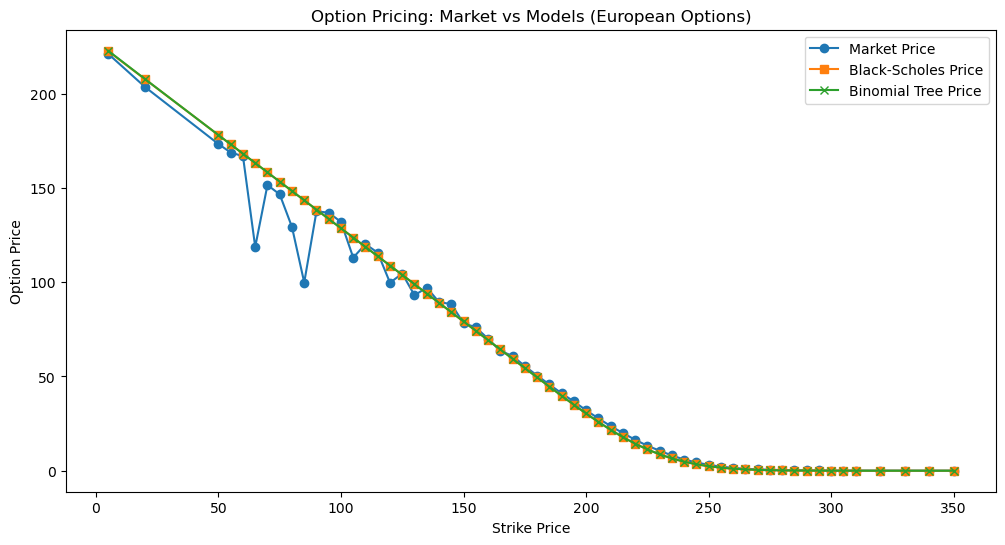

In [6]:
# Plot market prices vs model prices for European options (Black-Scholes vs Binomial)
plt.figure(figsize=(12, 6))
plt.plot(calls['strike'], calls['lastPrice'], label='Market Price', marker='o')
plt.plot(calls['strike'], calls['BS_price'], label='Black-Scholes Price', marker='s')
plt.plot(calls['strike'], calls['binomial_price'], label='Binomial Tree Price', marker='x')
plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Option Pricing: Market vs Models (European Options)')
plt.legend()
plt.show()

#### Greeks for American Options

In [7]:
def american_option_greeks(S0, K, T, r, q, sigma, N, optype='C'):
    price, C = binomial_american_fast_div(S0, K, T, r, q, sigma, N, optype)
    delta = (C[1] - C[0]) / (S0 * (np.exp(sigma * np.sqrt(T / N)) - 1))
    gamma = ((C[2] - C[1]) - (C[1] - C[0])) / (S0**2 * (np.exp(2 * sigma * np.sqrt(T / N)) - 1))
    return {'price': price, 'delta': delta, 'gamma': gamma}

#### Accuracy Check for American Options Against Yahoo Finance

In [8]:
calls['american_price'] = calls.apply(lambda row: binomial_american_fast_div(
    S0=stock_price,
    K=row['strike'],
    T=T,
    r=r,
    q=q,
    std=sigma,
    N=N,
    optype='C')[0], axis=1)

# Check accuracy by comparing American model price vs market price
calls['error'] = (calls['lastPrice'] - calls['american_price']) / calls['lastPrice'] * 100
accuracy = 100 - np.abs(calls['error']).mean()
print(f"Model accuracy: {accuracy:.2f}%")

Model accuracy: 75.88%


C:\Users\gongo\AppData\Local\Temp\ipykernel_13008\4171699286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['american_price'] = calls.apply(lambda row: binomial_american_fast_div(
C:\Users\gongo\AppData\Local\Temp\ipykernel_13008\4171699286.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['error'] = (calls['lastPrice'] - calls['american_price']) / calls['lastPrice'] * 100
